


# Gibbs sampling

Originally by Weichao Qiu.

If you find this ipython notebook is unclear or contains bugs, please post it on Piazza.
If there's an error says "something is undefined", please run the cell that contains the definition or use "menu -> cell -> run all above"

# Foreground/background classification.

Here we consider a model for foreground/background classification that can include spatial context. Intuitively, neighboring pixels in the image are likely to belong to the same class, i.e. are likely to be either all background or all foreground. This is a form of prior knowledge, or natural statistic, which can be learnt by analyzing natural images.

For pixel $i$, the foreground label is $ S_i = 1 $, and background label is $ S_i = -1 $.

The prior term in the energy encourages neighbouring pixels to have the same intensity ($N(i)$ is the set of pixels neighboring $i$):  
$ E_p[S] = \gamma \sum_{i} \sum_{j \in N(i)} { - S_i S_j} $

The data term is defined as:

$ E_d[S, I] = \eta \sum_{i} (I_i - S_i)^2 $


These two terms are combined to get the energy.

$ E[S] = E_p[S] + E_d[S, I] $

Then the posterior of the labeling $S$ given the image $I$ (with temperature parameter $T$) is

$ P(S|I) = \frac{1}{Z} \exp\left( - \frac{E[S]}{T} \right) $

The block of code below initializes the ipython notebook

In [15]:
# Initiialization code
%matplotlib inline
import numpy as np
# from pylab import imshow, show, get_cmap, imread, figure, subplots, title, subplot
import matplotlib.pyplot as plt
from numpy import random
import pylab as pl

The block of code below loads an image and normalizes it to the  range $[-1, 1]$.

original range: 0.1432450810038079 0.8001207787697899
remapped range: -1.0 1.0


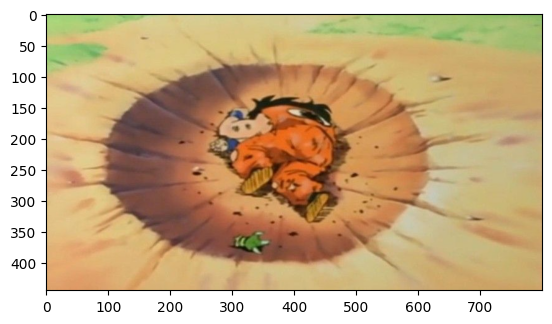

In [50]:
im = plt.imread('data/gibbs/yamcha.jpg')
plt.imshow(im)

def myimshow(state):
    plt.imshow(state, interpolation='nearest')

# Preprocess image to range (-1, 1)
def preproc_data(im, scale=0.1, debug=False):
    import skimage.color
    import skimage.transform

    # Ensure rescale treats the last dimension as channels
    tinyim = skimage.transform.rescale(im, scale, channel_axis=-1)
    grayim = skimage.color.rgb2gray(tinyim)

    # Linear map the data to -1, 1
    scale = grayim.max() - grayim.min()
    data = 2 * (grayim - grayim.min()) / scale - 1
    if debug:
        print('original range:', grayim.min(), grayim.max())
        print('remapped range:', data.min(), data.max())

    return [data, tinyim]

[data, im] = preproc_data(im, debug=True) # data is normalized image

The block of code below defines the neighborhood structure for the Gibbs sampler.

In [46]:
def getneighor(y, x, h, w): # get 4-side neighbor
    n = []
    if (x != 0): n.append((y, x-1))
    if (x != w-1): n.append((y, x+1))
    if (y != 0): n.append((y-1, x))
    if (y != h-1): n.append((y+1, x))
    return n

def poslist(h,w):
    '''Get point list of a grid'''
    pos = []
    for x in range(w):
        for y in range(h):
            pos.append((y, x))
    return pos

Define a utility function to compute energy.

In [47]:
def energy_prior(state, gamma):
    total = 0
    (h, w) = state.shape
    pos = poslist(h, w)
    for p in pos:
        neighbor = getneighor(p[0], p[1], h, w) # compute neighbor

        for n in neighbor:
            total += state[p[0]][p[1]] * state[n[0]][n[1]]
    E = - gamma * total
    return E

def energy_data(state, data, eta):
    E = eta * sum((data - state)**2)
    return E

def energy(state, data, gamma, eta):
    return energy_prior(state, gamma) + energy_data(state, data, eta)

Define the Gibbs sampler.

In [48]:
def gibbs_sampler(state, data, gamma, eta, debug=False): # 0/1 state
    (h, w) = state.shape
    new_state = state.copy()
    pos = poslist(h, w)
    for p in pos:
        neighbor_pos = getneighor(p[0], p[1], h, w)
        neighbor_value = [new_state[n[0]][n[1]] for n in neighbor_pos]

        tmp1 = -gamma * -1 * sum(neighbor_value) # x_i = -1
        tmp2 = -gamma * 1 * sum(neighbor_value) # x_i = 1

        # add data term
        v = data[p[0]][p[1]]
        tmp1 += eta * (v - (-1))**2 # x_i = -1
        tmp2 += eta * (v - 1)**2 #  x_i = 1

        tmp1 = np.exp(-tmp1)
        tmp2 = np.exp(-tmp2)

        p1 = tmp1 / (tmp1 + tmp2)
        prob = np.random.uniform() # roll a dice - Fixed: Use np.random.uniform()

        if (debug): print(p1)
        if (prob > p1):
            new_state[p[0]][p[1]] = 1
        else:
            new_state[p[0]][p[1]] = -1
    return new_state

# Animation: sample with data term included
Run this demo below; make sure to watch the animation as it happens!

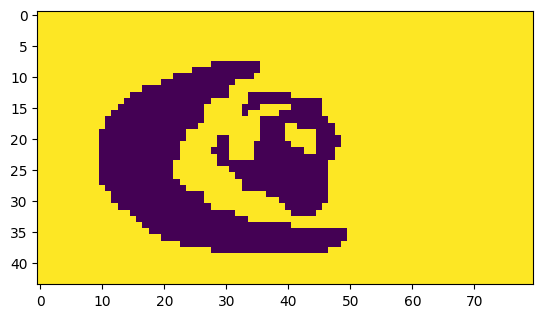

[array([11355.93673669, 11230.67161268, 12835.38246686, 10949.75944211,
       11740.20825078, 11857.50120969, 11795.31330906, 10626.86277962,
       10166.08087995, 12548.91023703, 10934.56100064, 10296.54124403,
       10706.73731676, 11339.81158773,  9972.46952474, 10690.88737127,
       10549.53947134, 11030.80783512,  9828.32808638,  9857.6037794 ,
        9767.06982316, 10519.93005735, 10303.09482546, 10086.91937545,
       10163.84135582,  9901.47733049, 10024.0658632 , 10840.60903824,
        8916.45703855, 10312.89631436,  9390.83409843, 10299.31859518,
       10552.72047837,  9759.09367606,  9330.79051308,  9028.59650844,
       10135.7968098 , 10182.69819274,  9813.91326932,  9881.5872509 ,
        9463.71373148,  9746.62431932, 10210.45197208,  9294.52654113,
        9940.84937742,  8941.70818749, 10503.64837226, 10401.24301109,
        8625.67991073, 10675.14641597,  8890.0053455 ,  9069.69361266,
        9980.32885007,  9648.03214095,  9995.49631499,  9811.31235999,
     

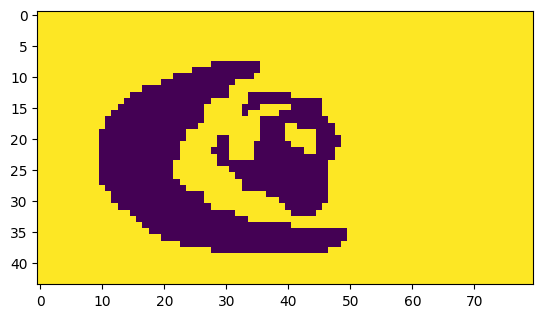

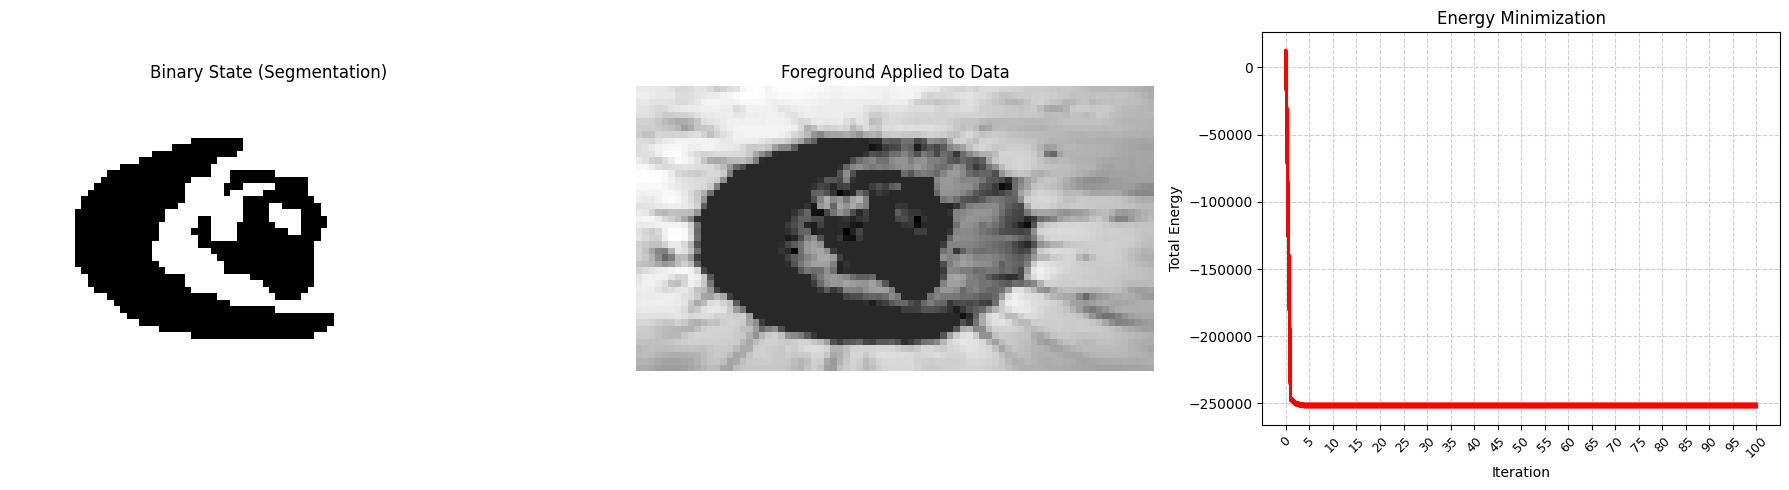

In [53]:
from IPython.display import display, clear_output
import time
random_seed = 67 # Change this in your experiment
random.seed(random_seed)

(h, w) = data.shape
mat = np.random.random((h,w))
mat[mat>0.5] = 1
mat[mat<=0.5] = -1
random_state = mat


# Initial the random state
init_state = random_state

# Set parameters
gamma = 20
eta = 100

new_state = random_state.copy()
E = [energy(init_state, data, gamma, eta)]# array of energies at each iteration


f, ax = plt.subplots() # prepare animation
for i in range(100):
    clear_output(wait=True)
    new_state = gibbs_sampler(new_state, data, gamma, eta)
    E.append(energy(new_state, data, gamma, eta))
    #time.sleep(1)
    myimshow(new_state)
    display(f)

#plt.title("Foreground")
#mask = (new_state==1)
#fg = data.copy()
#x=range(30)

#plt.imshow(fg, cmap='gray', interpolation='nearest')
#plt.subplots()
print(E)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Binary Segmentation
axes[0].imshow(new_state, cmap='gray', interpolation='nearest')
axes[0].set_title("Binary State (Segmentation)")
axes[0].axis('off')

# Plot 2: Masked Original Image
mask = (new_state == 1)
fg_masked = data.copy()
fg_masked[~mask] = 0 # Set background pixels to black (0)
axes[1].imshow(fg_masked, cmap='gray', interpolation='nearest')
axes[1].set_title("Foreground Applied to Data")
axes[1].axis('off')

# Plot 3: Energy vs Iteration
threshold = 1e-5
convergence_iter = None

#for i in range(1, len(E)):
#    change = abs((E[i]) - E[i-1])
#    if change < threshold:
        # Optional: Check a few steps ahead to ensure it's truly stable
        # (checks the next 5 steps if they exist)
#        if i + 5 < len(E):
#            future_changes = [abs(E[j] - E[j-1]) for j in range(i+1, i+6)]
#            if all(c < threshold for c in future_changes):
#                convergence_iter = i
#                break
#        else:
#            convergence_iter = i
#            break
x = range(len(E)) # Automatically matches the number of energy readings
if convergence_iter is not None:
    axes[2].axvline(x=convergence_iter, color='blue', linestyle='--', linewidth=1.5)

    # Add a label pointing to the line
    # We place the text slightly to the right of the line, at 90% of the max height
    y_pos = min(E) + (max(E) - min(E)) * 0.7
    axes[2].text(convergence_iter + 2, y_pos,
            f'Converged\n(Iter {convergence_iter})',
            color='blue', fontweight='bold')

    # Optional: Highlight the specific point
    axes[2].scatter([convergence_iter], [E[convergence_iter]], color='blue', zorder=5)
axes[2].plot(x, E, linewidth=2, color='red')
axes[2].set_title("Energy Minimization")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("Total Energy")
axes[2].grid(True, linestyle='--', alpha=0.6)
tick_interval = 5
ticks = np.arange(0, len(E), tick_interval)
axes[2].set_xticks(ticks)         # Apply the new ticks
axes[2].tick_params(axis='x', rotation=45, labelsize=9) # Rotate labels to prevent overlapping
# --------------------------

plt.tight_layout()
plt.show()

# Questions: Gibbs sampler
Set random_seed to a different value (and tell me what it is in your homework!)
1. Try a few different values of $ \gamma $, $ \eta $, including special case that only contains the prior term. What happens when the parameters change? (6 points)
2. Run with different images, plot your results. Find two or three images from the web or your image collection. Can you find an image that causes the model to identify the foreground poorly? Include the image that you use. (4 points)
3. Around what iteration does the sampler converge for the Einstein image with $ \gamma = 20 $ and $ \eta = 1 $ and how do you know it? Don't just say "the image stopped changing very much"! Hint: Check the energy of each state $S$.(6 points)